# Gradient descent

Is a cursial method for machine learning. But in general it's a way of optimising - finding values where the function depends on those values taking the minimum/maximum value. Here I'll try to implement a basic variation of gradient descent using only `numpy`. I'll explain each step to make everything clear.

In [1]:
import numpy as np
import plotly.graph_objects as go

## Task

Suppose we have classic linear regression task - we have array of point $(x_i, y_i)$ just like generated and visualised in the cell below:

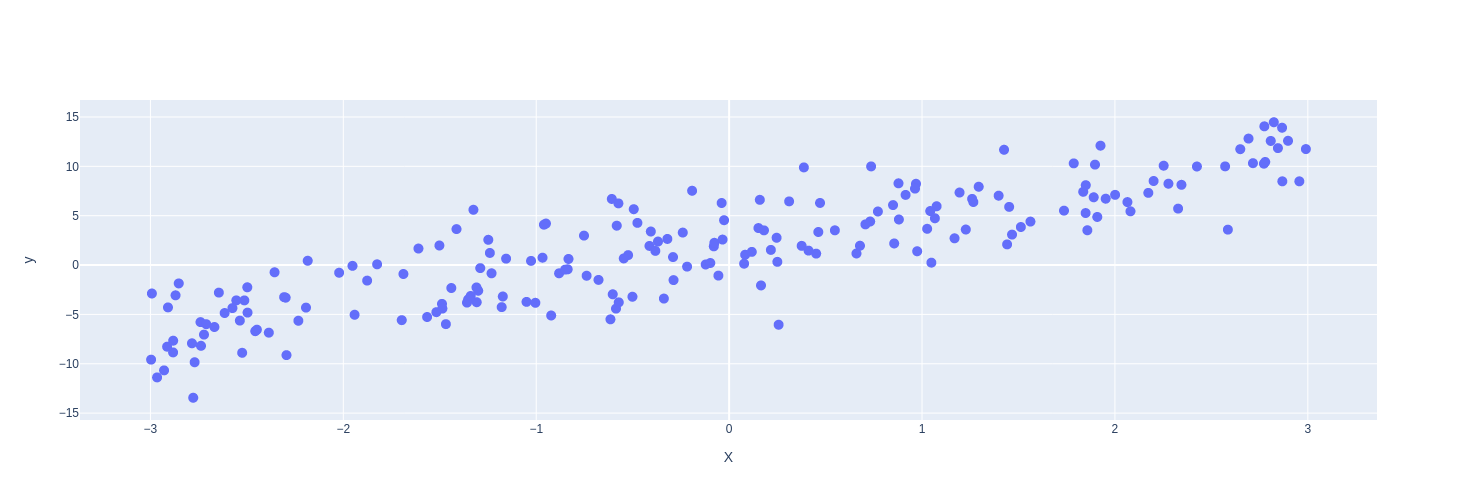

In [2]:
sample_size = 200

real_alpha = 3; real_beta = 2;

X = np.random.uniform(-3 , 3, sample_size)
y = X*real_alpha + real_beta + np.random.normal(0, 3, sample_size)


go.Figure(
    go.Scatter(x = X, y=y, mode = 'markers', marker_size = 10),
    layout={
        "xaxis_title" : "X",
        "yaxis_title" : "y",
        "width" : 1000,
        "height" : 500,
        "dragmode" : False
    }
)

We need to find such a function $y=x\alpha + \beta$ that produces the closest line to the array of points. More precisely to find $\alpha$ and $\beta$ that corresponds closes line.

We will use $MSE$ as a loss function:

$$L(\alpha, \beta)=\frac{\sum_{i=1}^n \left[(x_i\alpha + \beta) - y_i\right]^2}{n}$$

But the optimisation result will be the same with $SSE$ (Sum Square Errors):

$$L(\alpha, \beta)=\sum_{i=1}^n \left[(x_i\alpha + \beta) - y_i\right]^2$$

So we will use $SSE$ because it requires fewer operations.

The following code displays $SSE$ values for different values of $\alpha$ and $\beta$.

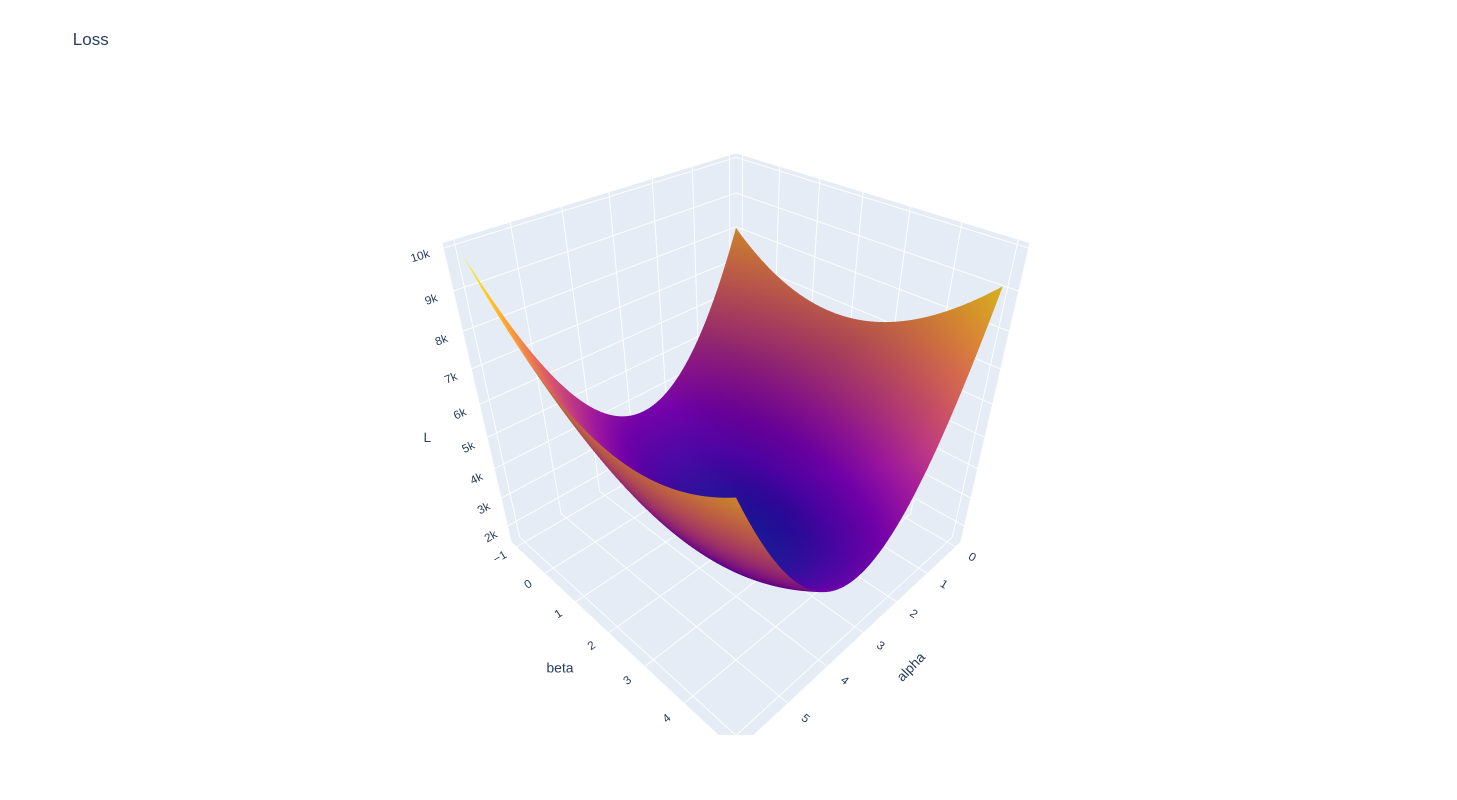

In [3]:
def sse_fun(y_true, y_pred):
    return ((y_true - y_pred)**2).sum()

def pltly_get_sse_surface(alphas, betas):
    
    grid = np.array([
        [sse_fun(y, alpha*X + beta) for beta in betas] 
        for alpha in alphas
    ]).T

    return go.Surface(
        z=grid, x=alphas, y=betas,
        hovertemplate="alpha:%{x}<br>beta:%{y}<br>Loss:%{z}<extra></extra>",
        showscale=False
    )

def pltly_get_sse_fig(data):
    fig = go.Figure(data=data)
    fig.update_layout(
        title='Loss', autosize=False,
        width=600, height=800,
        margin=dict(l=65, r=50, b=65, t=90),
        scene=dict(
            xaxis_title='alpha',
            yaxis_title='beta',
            zaxis_title='L'
        ),
        dragmode = "drawcircle"
    )
    return fig

alphas = np.linspace(real_alpha-3, real_alpha+3, 100)
betas = np.linspace(real_beta-3, real_beta+3, 100)
pltly_get_sse_fig([pltly_get_sse_surface(alphas, betas)])

## Theory

The idea is really simple - we need to pick a random point where we want to optimise and move in the direction of the fastest decreasing of function. Ok, let's say we start by picking point $(\alpha_0, \beta_0)$, then move to point $(\alpha_1, \beta_1)$ and so on. All we need for the optional point $(\alpha_i, \beta_i)$ is to determine the direction of the fastest decreasing of the $L$ function - antigradient of the function:

$$-\nabla L(\alpha, \beta)= -(\frac{\partial L}{\partial \alpha}, \frac{\partial L}{\partial \beta})$$

So we need some math with partial derivatives:

$$\frac{\partial L}{\partial \alpha}(\alpha, \beta)=2\sum_{i=1}^n (\alpha x_i+\beta - y_i)x_i;$$
$$\frac{\partial L}{\partial \beta}(\alpha, \beta)=2\sum_{i=1}^n \alpha x_i +\beta - y_i.$$

So from each $(\alpha_i,\beta_i)$ we can substitute the values into $\nabla L(\alpha, \beta)$ and get the direction we need to move. A good way to check if you have done everything right is to visualise the gradients at different points. The following cell defines a function to calculate gradint at a point and uses it to visualise the directions of the gradient. 
It would be cool to point cones tangential to the error graph, but plotly has some issues with cones pointing in case of large axis dimensionality, so I didn't get it right. But you can still see that the gradient realisation works well and all the cones point in the direction of minimisation.

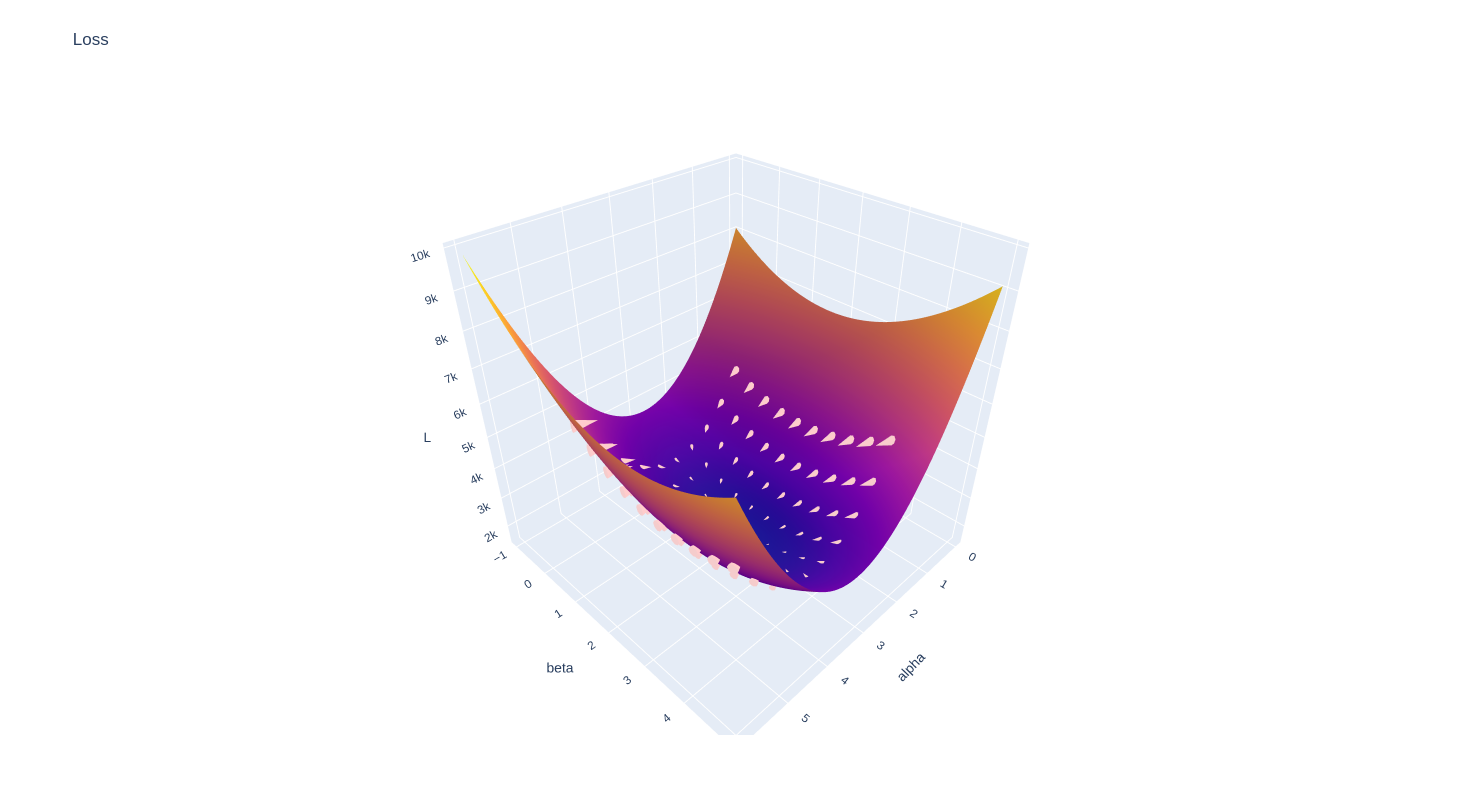

In [11]:
def sse_gradient(alpha, beta, X, y):
    n = len(X)
    
    expand_X = X[np.newaxis,:]
    expand_y = y[np.newaxis,:]
    expand_alpha = alpha[:, np.newaxis]
    expand_beta = beta[:, np.newaxis]

    alpha_grad = 2*(
        (np.dot(expand_alpha, expand_X) + expand_beta - expand_y)*expand_X
    ).sum(axis=1)/n
    beta_grad = 2*(expand_alpha*expand_X + expand_beta - expand_y).sum(axis=1)/n
    
    return (alpha_grad, beta_grad)

cones_a = np.linspace(real_alpha - 2, real_alpha + 2, 10)
cones_b = np.linspace(real_beta - 2, real_beta + 2, 10)
cones_a, cones_b = np.meshgrid(cones_a, cones_b)
cones_a = cones_a.ravel(); cones_b = cones_b.ravel()
cons_preds = np.dot(
    cones_a[:, np.newaxis], X[np.newaxis, :]
) + cones_b[:, np.newaxis]
cones_sse = ((cons_preds - y[np.newaxis, :])**2).sum(axis=1)

grad_a, grad_b = sse_gradient(cones_a, cones_b, X, y)
grad_a = -grad_a;grad_b = -grad_b
grad_L = np.zeros(grad_a.size)

pltly_get_sse_fig(
    data = [
        pltly_get_sse_surface(alphas, betas),
        go.Cone(
            x=cones_a, y=cones_b, z=cones_sse, 
            u=grad_a, v=grad_b, w=grad_L,
            showscale = False,
            colorscale=[
                'rgba(255, 0, 0, 0.2)', 
                'rgba(255, 0, 0, 0.2)'
            ]
        )
    ]
)

## Algorithm

Now, finally, to implement the optimisation algorithm. So we need

1. Select the point $(\alpha_0, \beta_0)$ (sets $i=0$);
2. Make an optimisation step like $(\alpha_{i+1}, \beta_{i+1}) = (\alpha_{i}, \beta_{i}) - lr*\nabla L(\alpha, \beta)$;
3. Check the stop criteria:
    - If it completes, stop the optimisation and select $(\alpha_i, \beta_i)$ as the result;
    - If it does not finish, $i:=i+1$ and return to step 2.
  
Where $lr$ - learning rate, parameter that determines the speed of the optimisation.

In [55]:
lr = 10e-2

# here is defining of initial point
alphas = [real_alpha + 3]
betas = [real_beta - 3]

# we don't use any complex stop criteria
# just 20 steps
for i in range(20):
    grad_a, grad_b = sse_gradient(
        np.array([alphas[-1]]), 
        np.array([betas[-1]]), X, y
    )

    alphas.append(alphas[-1] - lr*grad_a[0])
    betas.append(betas[-1] - lr*grad_b[0])